In [1]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC
from datetime import datetime
import pandas as pd
import time
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [152]:
# Definimos variables globales:
SCROLL_PAUSE_TIME = 0.5
DRIVER_DIR = "C:\\chromedriver_win32\\chromedriver.exe"
OUTPUT_DIR = "C:\\Users\\Matias\\Documents\\Matias\\Repositorios\\de_ruedas_ws\\outputs"

In [19]:
# Especificamos mapeos
map_order = {
    'Destacados': 1,
    'Más Nuevos': 2,
    'Más Antiguos': 3,
    'Más Caros': 4,
    'Más Baratos': 5,
    'Últimos Publicados': 6,
}

def get_id_precio(px):
    return int(px/100000)

In [26]:
# definimos parámetros de búsqueda
order = 'Últimos Publicados'
precio_min = 0 
precio_max = 8_000_000
kilometraje_max = 200000
anio_min = 2008
anio_max = datetime.now().year
brands = [
          # 'Alfa Romeo',
          # 'Audi',
          # 'BMW',
          # 'Chery',
          # 'Chevrolet',
          # 'Citroen',
          # 'DS',
          # 'Fiat',
          'Ford',
          'Geely',
          'Haval',
          'Honda',
          'Hyundai',
          'Jeep',
          'Kia',
          'Land Rover',
          'Mercedes Benz',
          'Mini Cooper',
          'Nissan',
          'Peugeot',
          'Renault',
          'Toyota',
          'Volkswagen',
          ]

### Función para cargar todos los autos de una marca

In [21]:
def get_browse_charged(brand):
    link = f"https://www.deruedas.com.ar/bus.asp?segmento=0&anio_1={anio_min}&anio_2={anio_max}&kilometraje={kilometraje_max}&precio_1={get_id_precio(precio_min)}&precio_2={get_id_precio(precio_max)}&order={map_order[order]}&marca={brand}"
    browser = webdriver.Chrome(DRIVER_DIR)
    browser.get(link)

    last_height = browser.execute_script("return document.body.scrollHeight")
    while True:
        # Scroll down to bottom
        browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")

        # Wait to load page
        time.sleep(SCROLL_PAUSE_TIME)

        # Calculate new scroll height and compare with last scroll height
        new_height = browser.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    return browser

### Función para obtener dolar

In [165]:
def get_usd_blue_price():
    link = "https://dolarhoy.com/cotizaciondolarblue"
    browser = webdriver.Chrome(DRIVER_DIR)
    browser.get(link)

    soup = BeautifulSoup(browser.page_source,"html.parser",multi_valued_attributes=None)
    dolar_page = soup.findAll("div", {"class": 'value'})
    
    return float(dolar_page[1].text.replace('$',''))

### Cargar la página por marca, ingresar a cada auto y guardar la data.

In [27]:
pd_datos_autos = pd.DataFrame()
for brand in brands:
    browser = get_browse_charged(brand)

    soup = BeautifulSoup(browser.page_source,"html.parser",multi_valued_attributes=None)
    soup_autos = soup.findAll("div", {"id": lambda value: value and value.startswith("car_")})

    lst_id_autos = []
    lst_link_autos = []
    for auto in soup_autos:
        lst_id_autos.append(auto.get('id'))
        lst_link_autos.append(f'https://www.deruedas.com.ar{auto.find("a").get("href")}')

    lst_dict_datos_auto = []
    for id_auto, link_auto in zip(lst_id_autos, lst_link_autos):
        dict_datos_auto = {}
        dict_datos_auto['id'] = id_auto
        dict_datos_auto['day'] = str(datetime.now().date())
        dict_datos_auto['marca'] = brand
        dict_datos_auto['link'] = link_auto
        


        # get soup page
        browser.get(link_auto)
        soup = BeautifulSoup(browser.page_source,"html.parser",multi_valued_attributes=None)
        
        # Cuadro superior (info principal)
        soup_info_principal = soup.find("div", {"id": 'divInfoPrincipal'})

        dict_datos_auto['nombre'] = soup_info_principal.find('span', {'class': 'titulo resaltar'}).find('h1').text
        dict_datos_auto['version'] = soup_info_principal.find('span', {'class': 'titulo resaltar'}).find('span').text

        # información de contacto
        soup_info_contacto = soup.find("div", {"id": 'divContactoVehiculo'})

        if soup_info_contacto.find('tbody').find('img') != None:
            dict_datos_auto['es_concesionario'] = 1
        else:
            dict_datos_auto['es_concesionario'] = 0
            
        try:
            dict_datos_auto['link_contacto'] = soup_info_contacto.find('tbody').findAll('a')[1].get('href')
        except:
            dict_datos_auto['link_contacto'] = None
            
        try:
            dict_datos_auto['nombre_contacto'] = soup_info_contacto.find('tbody').findAll('a')[1].text
        except:
            try:
                dict_datos_auto['nombre_contacto'] = soup_info_contacto.find('tbody').find('span').text
            except:
                dict_datos_auto['nombre_contacto'] = soup_info_contacto.find('tbody').find('b').text
                
        dict_datos_auto['ubicacion'] = soup_info_contacto.find('h2').text

        # Detalles en recuadros
        soup_info_datos = soup.find('div', {'id': 'divFichaVehiculo'}).findAll("div", {"class": 'recuadro'})
        lst_datos = soup_info_datos[0].findAll('b')

        lst_attrs = [
            'segmento',
            'ano',
            'combustible',
            'kilometraje',
            'precio',
            'permuta_por_menor',
            'permuta_por_mayor',
            'ultima_actualizacion',
            'provincia',
            'visitas'
            ]


        for i, dato in enumerate(lst_datos):
            dict_datos_auto[lst_attrs[i]] = dato.text

        dict_datos_auto['equipamiento'] = soup_info_datos[1].find('div', {'class':'texto'}).text
        dict_datos_auto['comentarios_vendedor'] = soup_info_datos[2].find('div', {'class':'texto'}).text.replace('\n','').replace('\t','')

        lst_dict_datos_auto.append(dict_datos_auto)


        # print(dict_datos_auto)
    pd_datos_autos = pd.concat([pd_datos_autos, pd.DataFrame(lst_dict_datos_auto)])
    
    browser.close()
    


In [ ]:
# guardamos los datos como csv
pd_datos_autos = pd_datos_autos.set_index('id')
date_str = str(datetime.now().date()).replace('-','_')
pd_datos_autos.to_csv(f'{date_str}_autos.csv')

## Análisis

In [223]:
pd_datos_autos = pd.read_csv('2022_06_17_autos.csv',index_col='id')

In [225]:
pd_datos_autos.groupby('marca')['marca'].count().sort_values(ascending=False)

marca
Volkswagen       791
Ford             623
Chevrolet        604
Peugeot          506
Renault          432
Fiat             412
Toyota           354
Citroen          158
Honda            104
Nissan            96
Audi              95
BMW               95
Jeep              91
Mercedes Benz     62
Chery             33
Hyundai           30
Mini Cooper       22
DS                12
Geely             10
Kia                9
Land Rover         8
Alfa Romeo         2
Haval              1
Name: marca, dtype: int64

In [227]:
set_equip = set()

pd_datos_autos['moneda'] = ['USD' if startswithU else 'ARS' for startswithU in pd_datos_autos['precio'].str.startswith('U')]
pd_datos_autos['precio'] = pd_datos_autos['precio'].str.replace('U','').str.replace('$','').str.replace('.','').astype(float)
tdc = get_usd_blue_price()
pd_datos_autos['precio_ars'] = [precio * tdc if moneda == 'USD' else precio for moneda, precio in zip(pd_datos_autos['moneda'],pd_datos_autos['precio'])]
pd_datos_autos['precio_usd'] = [precio / tdc if moneda == 'ARS' else precio for moneda, precio in zip(pd_datos_autos['moneda'],pd_datos_autos['precio'])]
pd_datos_autos['kilometraje'] = pd_datos_autos['kilometraje'].str.replace(' Km','').astype(float)
pd_datos_autos['ano'] = [int(datetime.now().year) if ano == '0 Km' else int(ano) for ano in pd_datos_autos['ano']]

for equip in pd_datos_autos['equipamiento'].str.split(','):
    equip = [eq.strip() for eq in equip]
    set_equip.update(set(equip))


lst_equip = list(set_equip)
for equip in list(set_equip):
    pd_datos_autos[equip] = [1 if equip in lst_eq else 0 for lst_eq in pd_datos_autos['equipamiento']]

def elimina_tildes(txt):
    return txt.replace('á','a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u')


pd_datos_autos.columns = [elimina_tildes(eq.lower().replace(' / ','/').replace(' ','_')) for eq in pd_datos_autos.columns]

# del pd_datos_autos['no_especificado']


C:\Users\matia\AppData\Local\Temp\ipykernel_296\1957329317.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pd_datos_autos['precio'] = pd_datos_autos['precio'].str.replace('U','').str.replace('$','').str.replace('.','').astype(float)


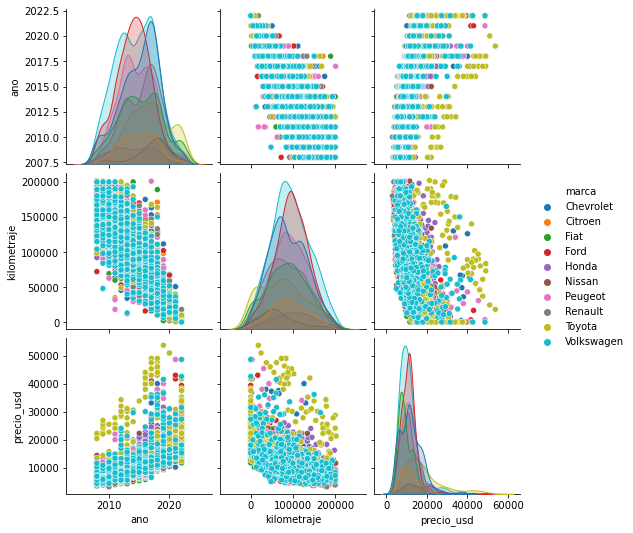

In [228]:
brands_in = [
          'Chevrolet',
          'Citroen',
          'Fiat',
          'Ford',
          'Honda',
          'Nissan',
          'Peugeot',
          'Renault',
          'Toyota',
          'Volkswagen',
          ]
sns.pairplot(pd_datos_autos[pd_datos_autos.apply(lambda x: x['marca'] in brands_in, axis=1)].reset_index()[['ano','kilometraje','precio_usd', 'marca']],hue='marca')

## Kmeans para clasificar tipos de autos según su equipamiento

### Seleccionamos cantidad de Clusters

In [229]:
(pd_datos_autos['no_especificado'] == 1).sum()/pd_datos_autos.shape[0]

0.09010989010989011

In [233]:
# Primero eliminamos el campo "no_especificado" y borramos del dataset los autos que no estén especificados.
del pd_datos_autos['no_especificado']

In [234]:
random_state = 1231
min_col_consider = list(pd_datos_autos.columns).index('precio_usd')+1
X = pd_datos_autos.iloc[:,min_col_consider::]

In [235]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

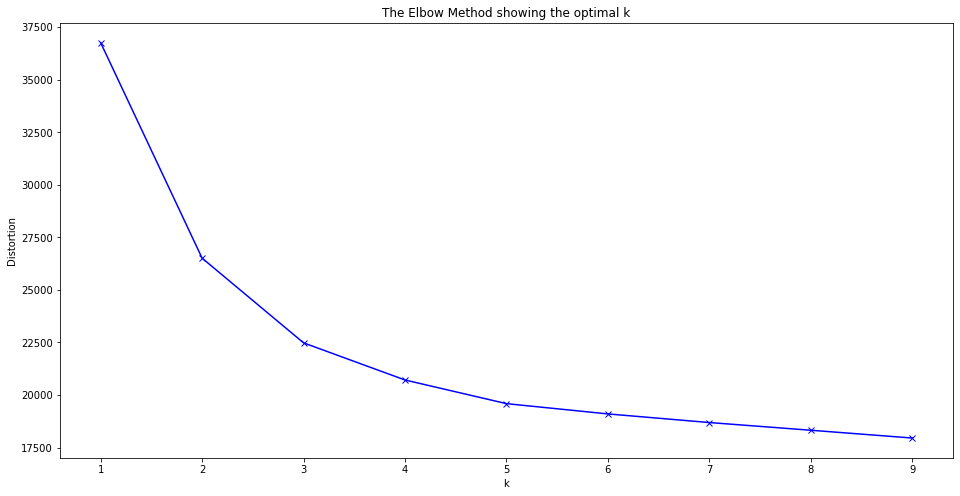

In [236]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Inspeccionamos los clusters

In [237]:
pd.options.display.max_columns = None
n_clusters = 3

In [238]:
pd_datos_autos['cl_equipamiento'] = KMeans(n_clusters=n_clusters, random_state=random_state).fit_predict(X)

In [239]:
counts_equip = pd_datos_autos.iloc[:,min_col_consider::].groupby('cl_equipamiento').sum()
count_per_group = pd_datos_autos.groupby('cl_equipamiento')['marca'].count()

sensor_de_lluvia


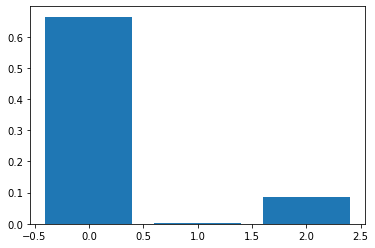

control_de_velocidad_crucero


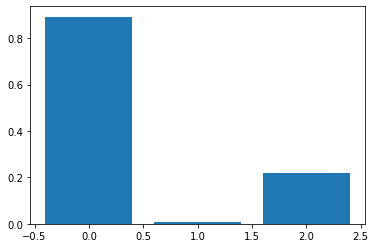

control_de_presion_de_neumaticos


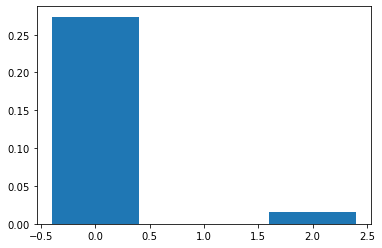

caja_automatica


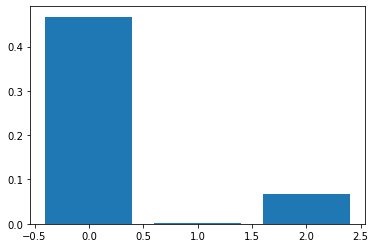

camara_de_estacionamiento_trasera


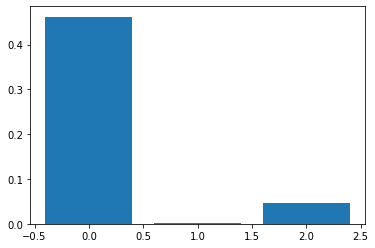

descapotable


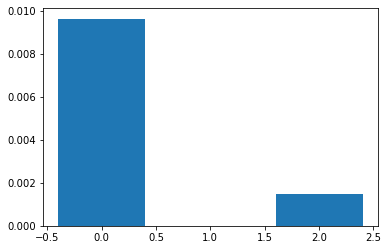

faros_regulables_desde_el_interior


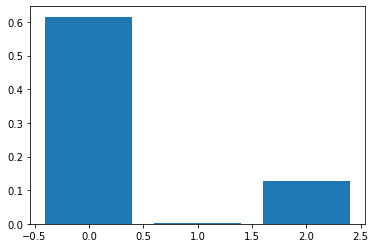

faros_de_xenon


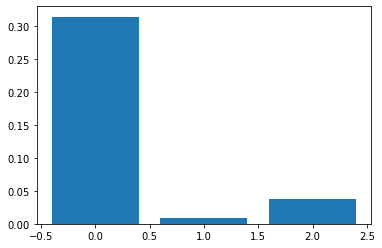

traba_para_niños


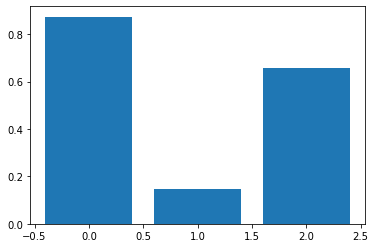

espejos_electricos


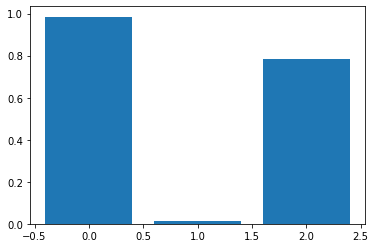

frenos_abs


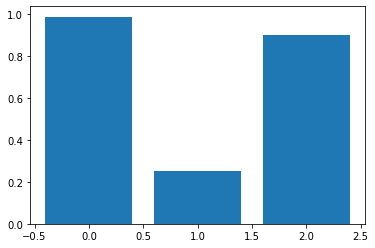

gps


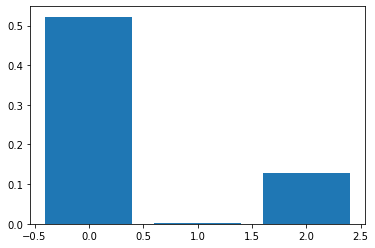

bluetooth


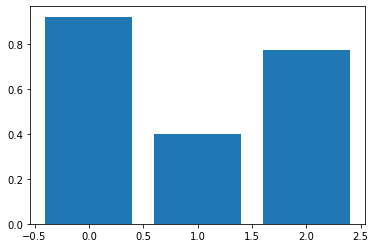

espejos_exteriores_retractiles_electricos


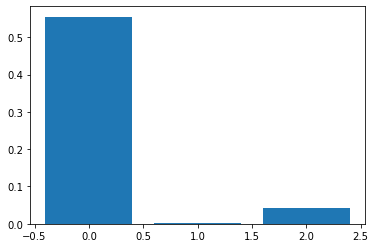

butacas_electricas


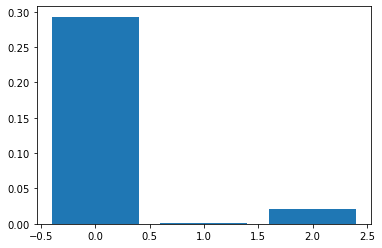

airbags


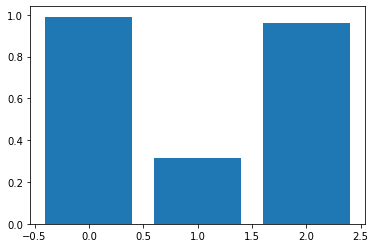

butacas_de_cuero


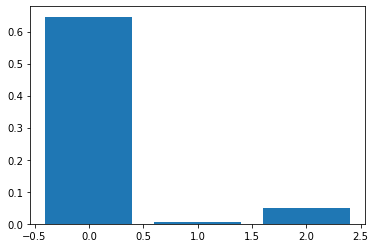

butacas_calefaccionadas


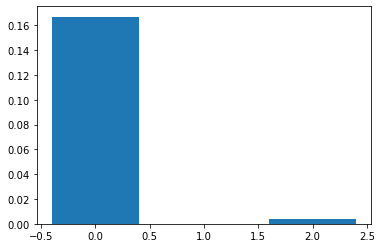

aire_acondicionado


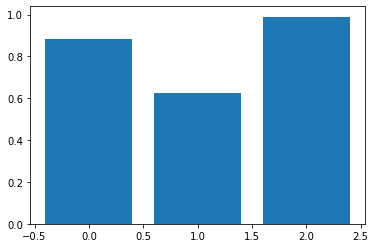

sensor_de_luz


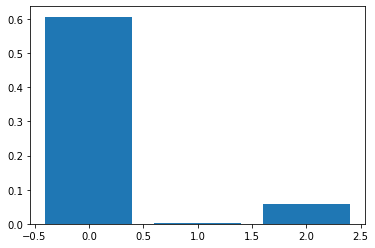

volante_de_cuero


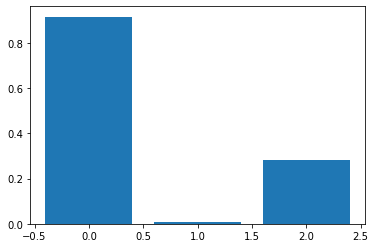

rueda_de_auxilio_de_igual_medida


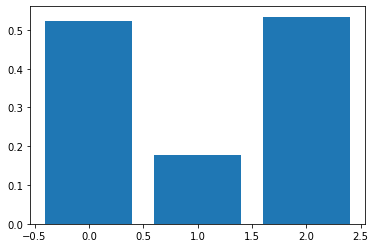

espejo_central_antideslumbrante


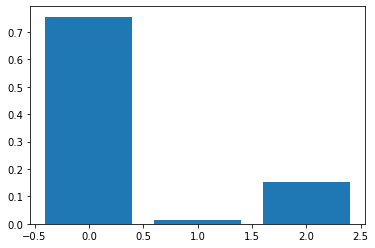

sistema_de_alerta_de_angulo_muerto


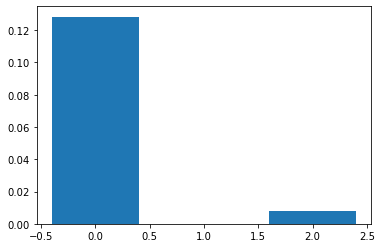

faros_direccionales


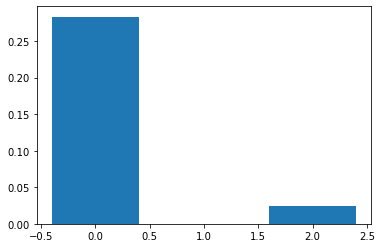

limpia/lava_faros


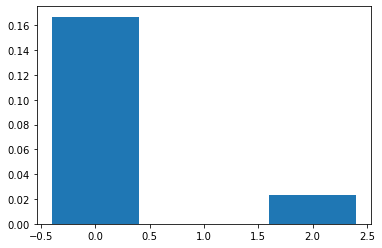

direccion_asistida


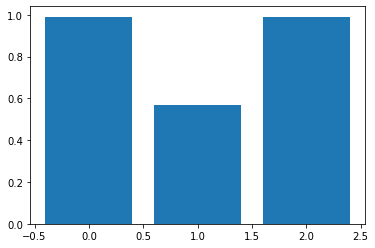

motor_turbo


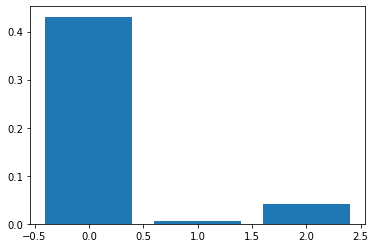

sistema_de_sonido_de_alto_rendimiento


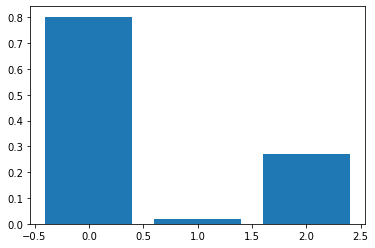

climatizador_automatico


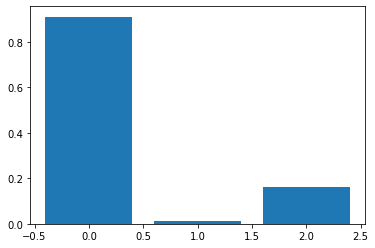

entrada_usb/auxiliar


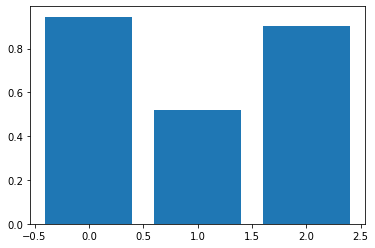

comandos_en_el_volante/satelital


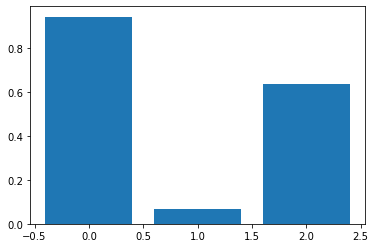

doble_traccion/4x4


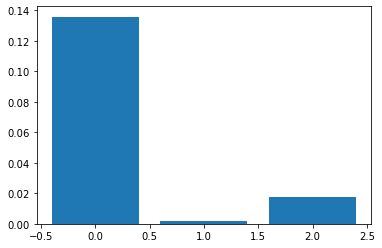

cierre_centralizado


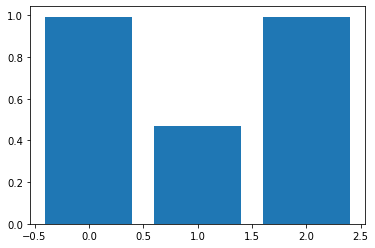

alarma


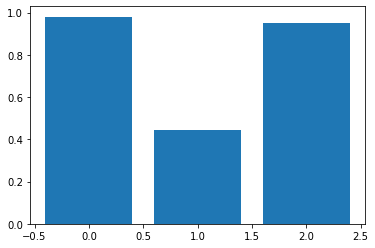

llantas_de_aleacion


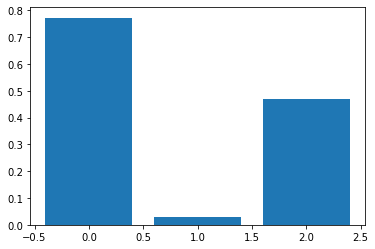

sensor_de_estacionamiento


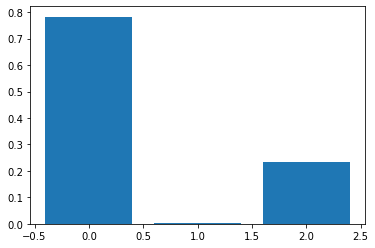

vidrios_electricos


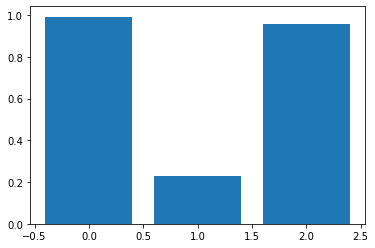

asistente_de_arranque_en_pendientes


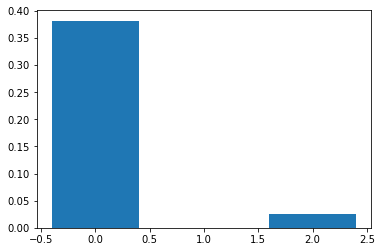

frenos_de_disco_en_las_cuatro_ruedas


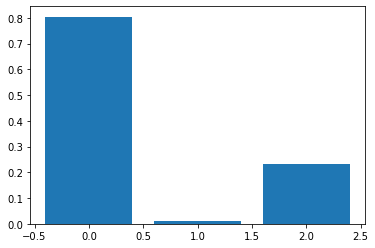

cierre_de_puertas_y_encendido_sin_llave


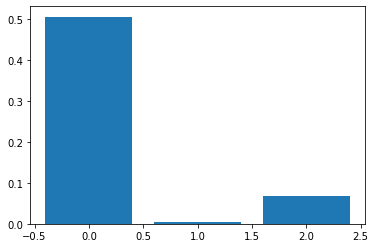

anclaje_de_asientos_infantiles_(isofix)


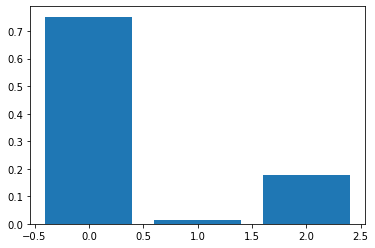

reproduce_cd/dvd


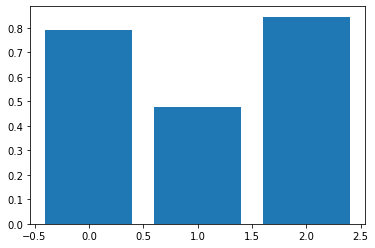

control_de_estabilidad_(esp)


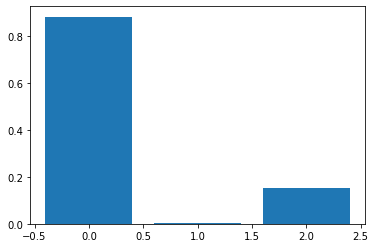

control_de_traccion


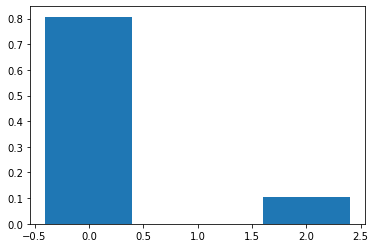

sistema_de_frenado_automatico


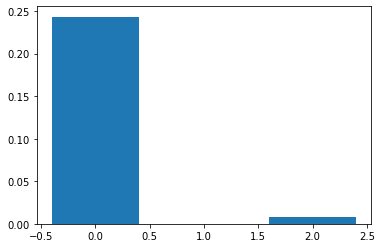

computadora_de_abordo


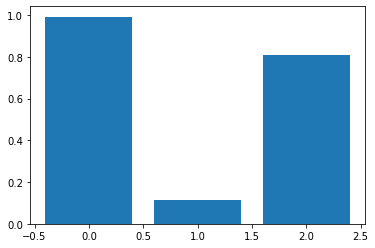

faros_antiniebla


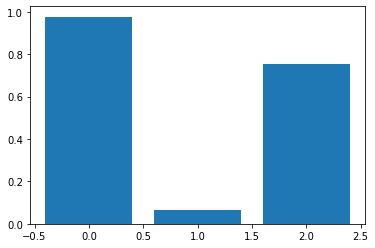

estacionamiento_automatico


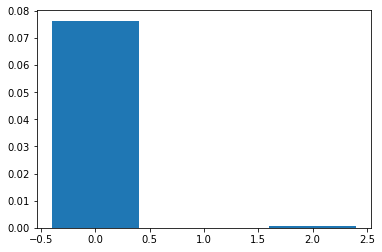

techo_panoramico_o_corredizo


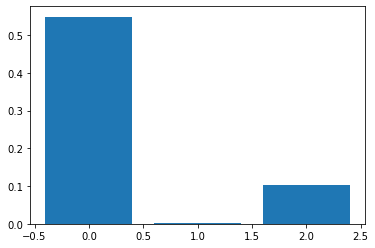

volante_regulable


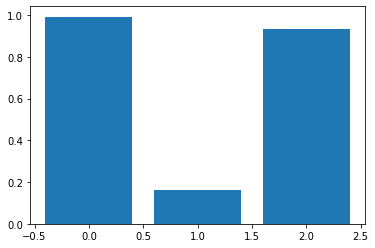

In [240]:
for i, column in enumerate(counts_equip.columns):
    print(column)
    plt.bar(counts_equip.index,counts_equip.iloc[:,i]/count_per_group)
    plt.show()

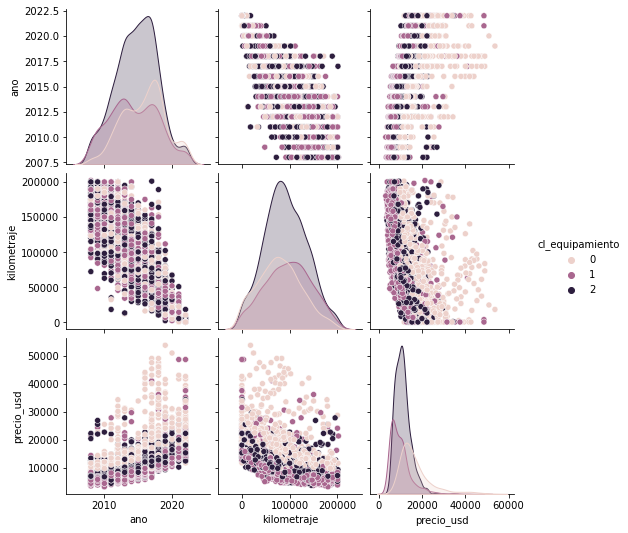

In [241]:
sns.pairplot(pd_datos_autos[pd_datos_autos.apply(lambda x: x['marca'] in brands_in, axis=1)].reset_index()[['ano','kilometraje','precio_usd', 'cl_equipamiento']],hue='cl_equipamiento')

In [250]:
corr = pd_datos_autos[['kilometraje', 'ano', 'precio_usd']].corr()
corr.style.background_gradient(cmap='coolwarm')

,kilometraje,ano,precio_usd
kilometraje,1.000000,-0.793440,-0.432128
ano,-0.793440,1.000000,0.450276
precio_usd,-0.432128,0.450276,1.000000


## Generamos un modelo por cluster de equipamiento

In [260]:
from sklearn.linear_model import LinearRegression

In [324]:
pd_datos_autos.segmento

id
car_474437    Autos Usados
car_535484    Autos Usados
car_542387    Autos Usados
car_519794    Autos Usados
car_485214    Autos Usados
                  ...     
car_462038    Autos Usados
car_449128    Autos Usados
car_440898    Autos Usados
car_434727    Autos Usados
car_92098     Autos Usados
Name: segmento, Length: 4550, dtype: object

In [325]:
pd_datos_autos = pd.concat([pd_datos_autos, 
                            pd.get_dummies(pd_datos_autos.cl_equipamiento),
                            pd.get_dummies(pd_datos_autos.segmento)], axis=1)

In [328]:
pd_model = pd_datos_autos[pd_datos_autos.marca == 'Chevrolet']

In [329]:

X = pd_model[['ano', 'kilometraje', 0, 1, 2, 'Autos Usados']]

y = pd_model['precio_usd']
reg = LinearRegression().fit(X, y)


C:\Users\matia\miniconda3\envs\deruedas\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [330]:
reg.score(X, y)

C:\Users\matia\miniconda3\envs\deruedas\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.6654990133617098

In [331]:
reg.coef_

array([ 8.17506237e+02, -1.68766685e-02,  1.82022905e+03,  1.82022905e+03,
       -1.40112144e+03, -1.40112144e+03, -4.19107608e+02, -4.19107608e+02,
       -2.58989348e+02])

In [332]:
reg.intercept_


-1632857.387701076

In [339]:
pd_model['prediccion'] = reg.predict(X)

C:\Users\matia\miniconda3\envs\deruedas\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\matia\AppData\Local\Temp\ipykernel_296\80008440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_model['prediccion'] = reg.predict(X)


In [340]:
pd_model['dif_pred'] = pd_model['prediccion'] - pd_model['precio_usd']

C:\Users\matia\AppData\Local\Temp\ipykernel_296\1957524604.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_model['dif_pred'] = pd_model['prediccion'] - pd_model['precio_usd']


In [346]:
pd_model.sort_values('dif_pred',ascending = False).iloc[0][['cl_equipamiento','precio_usd','prediccion','dif_pred']]

cl_equipamiento               2
precio_usd         10185.185185
prediccion         17887.978778
dif_pred            7702.793593
Name: car_541873, dtype: object

In [347]:
pd_model.sort_values('dif_pred',ascending = False).iloc[0]['link']

'https://www.deruedas.com.ar/vendo/Chevrolet/Onix/Usado/Mendoza?cod=541873&montoEntrega=11000000'